In [1]:
import numpy as np
import pandas as pd
import random
import time
import math
import os
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter as sg_filter
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
from dateutil import parser
from pathlib import Path
import json 
import shutil

from wattile.data_reading import read_dataset_from_file
from wattile.buildings_processing import correct_predictor_columns, correct_timestamps, rolling_stats, input_data_split
from wattile.time_processing import add_processed_time_columns
PROJECT_DIRECTORY = Path().resolve().parent.parent

### reading configs

In [2]:
"""
For this example, we will be using the default configs.
Check out the docs for an explaination of each config.
"""
##################################################################################
# choose the configs file to use as an input
##################################################################################
# # main configs file
# with open(PROJECT_DIRECTORY / "wattile" / "configs" / "configs.json", "r") as f:
#     configs = json.load(f)
##################################################################################
# code testing configs file
with open(PROJECT_DIRECTORY / "tests" / "fixtures" / "test_configs.json", "r") as f:
    configs = json.load(f)
##################################################################################

exp_dir = PROJECT_DIRECTORY / "notebooks" / "exp_dir"
if exp_dir.exists():
    shutil.rmtree(exp_dir)
exp_dir.mkdir()

configs["exp_dir"] = str(exp_dir)
configs["data_dir"] = str(PROJECT_DIRECTORY / "data")

configs

{'building': 'Synthetic Site',
 'target_var': 'Synthetic Site Electricity Main Total Power',
 'start_time': '2018-01-01T00:00:00-07:00',
 'end_time': '2022-01-01T00:00:00-07:00',
 'data_time_interval_mins': 1,
 'predictor_columns': ['Synthetic Weather Station Dew Point Temperature',
  'Synthetic Weather Station Diffuse Horizontal Irradiance',
  'Synthetic Weather Station Direct Normal Irradiance',
  'Synthetic Weather Station Dry Bulb Temperature',
  'Synthetic Weather Station Global Horizontal Irradiance',
  'Synthetic Weather Station Relative Humidity',
  'Synthetic Weather Station Wind Speed'],
 'arch_version': 4,
 'exp_id': 'Debugging_for_rolling_stats',
 'arch_type': 'RNN',
 'arch_type_variant': 'lstm',
 'transformation_method': 'minmaxscale',
 'train_batch_size': 5,
 'val_batch_size': 1,
 'convert_csvs': False,
 'exp_dir': 'C:\\Users\\JKIM4\\Documents\\GitHub\\intelligentcampus-pred-analytics\\notebooks\\exp_dir',
 'data_dir': 'C:\\Users\\JKIM4\\Documents\\GitHub\\intelligentcamp

### override config if necessary

In [3]:
# configs["feat_stats"]["window_width"] = '15min'
# configs["feat_stats"]["window_increment"] = '15min'

### reading data

In [4]:
site = configs['building']

In [5]:
data = read_dataset_from_file(configs)
data

,Synthetic Weather Station Dew Point Temperature,Synthetic Weather Station Diffuse Horizontal Irradiance,Synthetic Weather Station Direct Normal Irradiance,Synthetic Weather Station Dry Bulb Temperature,Synthetic Weather Station Global Horizontal Irradiance,Synthetic Weather Station Relative Humidity,Synthetic Weather Station Wind Speed,Synthetic Site Electricity Main Total Power
Timestamp,,,,,,,,
2021-12-01 07:00:00+00:00,15.413733,-1.525850,-0.005199,56.408001,-1.810825,17.930000,10.457981,104.800003
2021-12-01 07:01:00+00:00,15.183906,-1.496226,0.207964,56.174000,-1.841866,17.879999,11.265539,96.650002
2021-12-01 07:02:00+00:00,14.891221,-1.441191,0.457520,55.886002,-1.873579,17.809999,12.777752,96.199997
2021-12-01 07:03:00+00:00,14.836164,-1.371754,0.473117,55.796001,-1.860084,17.820000,12.694983,95.599998
2021-12-01 07:04:00+00:00,14.782966,-1.317349,0.545903,55.723999,-1.843271,17.820000,11.632407,100.650002
...,...,...,...,...,...,...,...,...
2021-12-08 06:55:00+00:00,11.210565,-1.487212,-0.254757,42.285198,-1.814939,24.680000,0.000000,109.664803
2021-12-08 06:56:00+00:00,11.190062,-1.445182,-0.233960,41.997200,-1.852901,24.930000,0.000000,107.002800
2021-12-08 06:57:00+00:00,11.223961,-1.396302,-0.145575,41.669601,-1.841248,25.290001,3.545647,106.480400


### feature extraction

In [6]:
# assert we have the correct columns and order them
data = correct_predictor_columns(configs, data)

# sort and trim data specified time period
data = correct_timestamps(configs, data)

# Add time-based features
data = add_processed_time_columns(data, configs)

# Add statistics features
data = rolling_stats(data, configs)

data

,Synthetic Weather Station Dew Point Temperature_min,Synthetic Weather Station Diffuse Horizontal Irradiance_min,Synthetic Weather Station Direct Normal Irradiance_min,Synthetic Weather Station Dry Bulb Temperature_min,Synthetic Weather Station Global Horizontal Irradiance_min,Synthetic Weather Station Relative Humidity_min,Synthetic Weather Station Wind Speed_min,sin_HOD_min,cos_HOD_min,DOW_binary_reg_0_min,...,DOW_binary_reg_0_mean,DOW_binary_reg_1_mean,DOW_binary_reg_2_mean,DOW_binary_reg_3_mean,DOW_binary_reg_4_mean,DOW_binary_reg_5_mean,DOW_binary_reg_6_mean,sin_MOY_mean,cos_MOY_mean,Synthetic Site Electricity Main Total Power
Timestamp,,,,,,,,,,,,,,,,,,,,,
2021-12-01 07:00:00+00:00,15.413733,-1.525850,-0.005199,56.408001,-1.810825,17.930000,10.457981,0.965926,-2.588190e-01,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.493776,0.869589,104.800003
2021-12-01 07:15:00+00:00,14.782966,-1.496226,-0.540707,55.112000,-1.873579,17.809999,9.395406,0.946930,-3.214395e-01,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.493776,0.869589,103.650002
2021-12-01 07:30:00+00:00,15.474850,-1.379412,-1.741706,54.608002,-1.918852,18.690001,8.612455,0.923880,-3.826834e-01,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.493776,0.869589,98.050003
2021-12-01 07:45:00+00:00,16.614972,-1.642929,-2.147240,53.743999,-2.029242,19.320000,4.503084,0.896873,-4.422887e-01,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.493776,0.869589,98.349998
2021-12-01 08:00:00+00:00,16.413343,-1.480409,-0.426325,52.807999,-1.958610,21.090000,3.746977,0.866025,-5.000000e-01,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.493776,0.869589,102.949997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-08 06:00:00+00:00,11.961447,-1.673728,-1.211398,41.388802,-1.909901,25.160000,0.000000,0.998135,-1.608123e-16,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.385663,0.922640,104.668396
2021-12-08 06:15:00+00:00,11.008480,-1.489343,-0.504314,41.646198,-1.936419,24.240000,0.000000,0.997859,-6.540313e-02,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.385663,0.922640,102.709602
2021-12-08 06:30:00+00:00,10.851442,-1.571301,-0.655083,42.024200,-1.834018,23.760000,0.000000,0.991445,-1.305262e-01,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.385663,0.922640,105.972198


In [7]:
# data = data.reset_index(drop=True)
# data

### Three types of S2S model structures with different attention model
class `S2S_Model`: vanilla S2S model without attention model

class `S2S_BA_Model`: S2S model with Bahdanau Attention model (https://machinelearningmastery.com/the-bahdanau-attention-mechanism/)

class `S2S_LA_Model`: S2S model with Luong Attention module (https://machinelearningmastery.com/the-luong-attention-mechanism/). `attn` module is part of `S2S_LA_Model`

Each model structure can select RNN cell type, including `lstm`, `RNN`, `gru`

Three model structures are parallel. Each run defines one model structure. The selection of model structure is only used for sensitivity analysis and comparison study. In the future when we decide one model structure, we can delete the rest options.

In [8]:
#########################################################################################
# building the S2S model
class S2S_Model(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size, use_cuda):
        super(S2S_Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.cell_type = cell_type

        if self.cell_type not in ['rnn', 'gru', 'lstm']:
            raise ValueError(self.cell_type, " is not an appropriate cell type. Please select one of rnn, gru, or lstm.")
        if self.cell_type == 'rnn':
            self.Ecell = nn.RNNCell(self.input_size, self.hidden_size)
            self.Dcell = nn.RNNCell(1, self.hidden_size)
        if self.cell_type == 'gru':
            self.Ecell = nn.GRUCell(self.input_size, self.hidden_size)
            self.Dcell = nn.GRUCell(1, self.hidden_size)
        if self.cell_type == 'lstm':
            self.Ecell = nn.LSTMCell(self.input_size, self.hidden_size)
            self.Dcell = nn.LSTMCell(1, self.hidden_size)

        self.lin_usage = nn.Linear(self.hidden_size, 1)
        self.use_cuda = use_cuda
        self.init()

    # function to intialize weight parameters. Refer to Saxe at al. paper that explains why to use orthogonal init weights
    def init(self):
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
        elif self.cell_type == 'lstm':
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
                    init.constant_(p.data[self.hidden_size:2*self.hidden_size], 1.0)

    def consume(self, x):
        # encoder forward function
        # for rnn and gru
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            h = torch.zeros(x.shape[0], self.hidden_size)
            if self.use_cuda:
                h = h.cuda()
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
            pred_usage = self.lin_usage(h)
        # for lstm
        elif self.cell_type == 'lstm':
            h0 = torch.zeros(x.shape[0], self.hidden_size)
            c0 = torch.zeros(x.shape[0], self.hidden_size)
            if self.use_cuda:
                h0 = h0.cuda()
                c0 = c0.cuda()
            h = (h0, c0)
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
            pred_usage = self.lin_usage(h[0])
        return pred_usage, h

    def predict(self, pred_usage, h, target_length):
        # decoder forward function
        preds = []
        # for rnn and gru
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            for step in range(target_length):
                h = self.Dcell(pred_usage, h)
                pred_usage = self.lin_usage(h)
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        # for lstm
        elif self.cell_type == 'lstm':
            for step in range(target_length):
                h = self.Dcell(pred_usage, h)
                pred_usage = self.lin_usage(h[0])
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        return preds

#########################################################################################
# Bahdanau Attention model
# refer to : AuCson github code
# building the model
class S2S_BA_Model(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size, use_cuda):
        super(S2S_BA_Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.use_cuda = use_cuda
        self.cell_type = cell_type

        if self.cell_type not in ['rnn', 'gru', 'lstm']:
            raise ValueError(self.cell_type, " is not an appropriate cell type. Please select one of rnn, gru, or lstm.")
        if self.cell_type == 'rnn':
            self.Ecell = nn.RNNCell(self.input_size, self.hidden_size)
            self.Dcell = nn.RNNCell(1+self.hidden_size, self.hidden_size)
        if self.cell_type == 'gru':
            self.Ecell = nn.GRUCell(self.input_size, self.hidden_size)
            self.Dcell = nn.GRUCell(1+self.hidden_size, self.hidden_size)
        if self.cell_type == 'lstm':
            self.Ecell = nn.LSTMCell(self.input_size, self.hidden_size)
            self.Dcell = nn.LSTMCell(1+self.hidden_size, self.hidden_size)

        self.Wattn_energies = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.Wusage = nn.Linear(self.hidden_size, 1)
        self.Wout = nn.Linear(1+self.hidden_size*2, self.hidden_size)
        self.v = nn.Parameter(torch.rand(self.hidden_size))
        stdv = 1./math.sqrt(self.v.size(0))
        self.v.data.normal_(mean=0, std=stdv)
        self.init()

# function to intialize weight parameters
    def init(self):
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
        elif self.cell_type == 'lstm':
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
                    init.constant_(p.data[self.hidden_size:2*self.hidden_size], 1.0)

    def consume(self, x):
        # for rnn and gru
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            # encoder forward function
            h = torch.zeros(x.shape[0], self.hidden_size)
            encoder_outputs = torch.zeros(x.shape[1], x.shape[0], self.hidden_size)
            if self.use_cuda:
                h = h.cuda()
                encoder_outputs = encoder_outputs.cuda()
            # encoder part
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
                encoder_outputs[T] = h
            pred_usage = self.Wusage(h)
        # for lstm
        elif self.cell_type == 'lstm':
            h0 = torch.zeros(x.shape[0], self.hidden_size)
            c0 = torch.zeros(x.shape[0], self.hidden_size)
            encoder_outputs = torch.zeros(x.shape[1], x.shape[0], self.hidden_size)
            if self.use_cuda:
                h0 = h0.cuda()
                c0 = c0.cuda()
                encoder_outputs = encoder_outputs.cuda()
            h = (h0, c0)
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
                encoder_outputs[T] = h[0]
            pred_usage = self.Wusage(h[0])
        return pred_usage, h, encoder_outputs

    def predict(self, pred_usage, h, encoder_outputs, target_length):
        # decoder with attention function
        preds = []
        # for rnn and gru
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            for step in range(target_length):
                h_copies = h.expand(encoder_outputs.shape[0], -1, -1)
                energies = torch.tanh(self.Wattn_energies(torch.cat((h_copies, encoder_outputs), 2)))
                score = torch.sum(self.v * energies, dim=2)
                attn_weights = score.t()
                attn_weights = torch.softmax(attn_weights, dim=1).unsqueeze(1)
                context = attn_weights.bmm(encoder_outputs.transpose(0,1)).squeeze(1)
                gru_input = torch.cat((pred_usage, context), 1)
                h = self.Dcell(gru_input, h)
                output = self.Wout(torch.cat((pred_usage, h, context), 1))
                pred_usage = self.Wusage(output)
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        # for lstm
        elif self.cell_type == 'lstm':
            for step in range(target_length):
                h_copies = h[0].expand(encoder_outputs.shape[0], -1, -1)
                energies = torch.tanh(self.Wattn_energies(torch.cat((h_copies, encoder_outputs), 2)))
                score = torch.sum(self.v * energies, dim=2)
                attn_weights = score.t()
                attn_weights = torch.softmax(attn_weights, dim=1).unsqueeze(1)
                context = attn_weights.bmm(encoder_outputs.transpose(0,1)).squeeze(1)
                gru_input = torch.cat((pred_usage, context), 1)
                h = self.Dcell(gru_input, h)
                output = self.Wout(torch.cat((pred_usage, h[0], context), 1))
                pred_usage = self.Wusage(output)
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        return preds

#############################################################################################3
# Luong Attention module
class Attn(torch.nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, " is not an appropriate attention method, please select one of dot, general, or concat.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, self.hidden_size)
        if self.method == 'concat':
            self.attn = nn.Linear(2*self.hidden_size, self.hidden_size)
            self.v = nn.Parameter(torch.rand(self.hidden_size))
            stdv = 1./math.sqrt(self.v.size(0))
            self.v.data.normal_(mean=0, std=stdv)

    def dot_score(self, hidden, encoder_output):
        attn_energies = torch.sum(hidden*encoder_output, dim=2)
        return attn_energies

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        attn_energies = torch.sum(hidden*energy, dim=2)
        return attn_energies

    def concat_score(self, hidden, encoder_output):
        energy = torch.tanh(self.attn(torch.cat((hidden.expand(encoder_output.shape[0], -1, -1),
                            encoder_output), 2)))
        return torch.sum(self.v * energy, dim=2)

    # calculate the attention weights (energies) based on the given method
    def forward(self, hidden, encoder_outputs):
        if self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)
        elif self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        attn_energies = attn_energies.t()
        attn_weights = torch.softmax(attn_energies, dim=1).unsqueeze(1)
        return attn_weights

#########################################################################################
#  building the S2S LA model
class S2S_LA_Model(nn.Module):
    def __init__(self, cell_type, attn_method, input_size, hidden_size, use_cuda):
        super(S2S_LA_Model, self).__init__()
        self.cell_type = cell_type
        self.attn_method = attn_method
        self.input_size = input_size
        self.hidden_size = hidden_size

        if self.cell_type == 'rnn':
            self.Ecell = nn.RNNCell(self.input_size, self.hidden_size)
            self.Dcell = nn.RNNCell(1, self.hidden_size)
        if self.cell_type == 'gru':
            self.Ecell = nn.GRUCell(self.input_size, self.hidden_size)
            self.Dcell = nn.GRUCell(1, self.hidden_size)
        if self.cell_type == 'lstm':
            self.Ecell = nn.LSTMCell(self.input_size, self.hidden_size)
            self.Dcell = nn.LSTMCell(1, self.hidden_size)

        self.lin_usage = nn.Linear(hidden_size, 1)
        self.lin_concat = nn.Linear(hidden_size*2, hidden_size)
        self.attn = Attn(self.attn_method, self.hidden_size)
        self.use_cuda = use_cuda
        self.init()

    # function to intialize weight parameters
    def init(self):
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
        elif self.cell_type == 'lstm':
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
                    init.constant_(p.data[self.hidden_size:2*self.hidden_size], 1.0)

    def consume(self, x):
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            # encoder forward function
            h = torch.zeros(x.shape[0], self.hidden_size)
            encoder_outputs = torch.zeros(x.shape[1], x.shape[0], self.hidden_size)
            if self.use_cuda:
                h = h.cuda()
                encoder_outputs = encoder_outputs.cuda()
            # encoder part
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
                encoder_outputs[T] = h
            pred_usage = self.lin_usage(h)
        elif self.cell_type == 'lstm':
            h0 = torch.zeros(x.shape[0], self.hidden_size)
            c0 = torch.zeros(x.shape[0], self.hidden_size)
            encoder_outputs = torch.zeros(x.shape[1], x.shape[0], self.hidden_size)
            if self.use_cuda:
                h0 = h0.cuda()
                c0 = c0.cuda()
                encoder_outputs = encoder_outputs.cuda()
            h = (h0, c0)
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
                encoder_outputs[T] = h[0]
            pred_usage = self.lin_usage(h[0])
        return pred_usage, h, encoder_outputs

    def predict(self, pred_usage, h, encoder_outputs, target_length):
        # decoder with attention function
        preds = []
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            for step in range(target_length):
                h = self.Dcell(pred_usage, h)
                attn_weights = self.attn(h, encoder_outputs)
                context = attn_weights.bmm(encoder_outputs.transpose(0,1))
                context = context.squeeze(1)
                concat_input = torch.cat((h, context), 1)
                concat_output = torch.tanh(self.lin_concat(concat_input))
                pred_usage = self.lin_usage(concat_output)
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        elif self.cell_type == 'lstm':
            for step in range(target_length):
                h = self.Dcell(pred_usage, h)
                attn_weights = self.attn(h[0], encoder_outputs)
                context = attn_weights.bmm(encoder_outputs.transpose(0,1))
                context = context.squeeze(1)
                concat_input = torch.cat((h[0], context), 1)
                concat_output = torch.tanh(self.lin_concat(concat_input))
                pred_usage = self.lin_usage(concat_output)
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        return preds

### main function

The `main` function process the data into three-dimensional for S2S model, train the model, and test the restuls

- def `generate_windows`: an important procedure to convert 2-dimensional data into 3-dimensional for modeling

- def `quantile_loss`: loss function with quntile number as parameter. For now, it cannot support list of quantiles as parameters.

In [9]:
#################################################################################################################################################
# main function
def main(seed, cuda, cell_type, attention_model, la_method, window_source_size,
            window_target_size, epochs, batch_size, hs, save_model, loss_function_qs, normalization):
    t0 = time.time()
    np.random.seed(seed)
    torch.manual_seed(seed)

    # loss function, qs here is an integer, not a list of integer
    def quantile_loss(output, target, qs, window_target_size):
        """
        Computes loss for quantile methods.
        :param output: (Tensor)
        :param target: (Tensor)
        :param qs: (int)
        :param window_target_size: (int)
        :return: (Tensor) Loss for this study (single number)
        """

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        resid = target - output
        tau = torch.tensor([qs], device=device).repeat_interleave(window_target_size)

        alpha = 0.001
        log_term = torch.zeros_like(resid, device=device)
        log_term[resid < 0] = torch.log(1 + torch.exp(resid[resid < 0] / alpha)) - (
            resid[resid < 0] / alpha
        )
        log_term[resid >= 0] = torch.log(1 + torch.exp(-resid[resid >= 0] / alpha))
        loss = resid * tau + alpha * log_term
        loss = torch.mean(torch.mean(loss, 0))

        return loss
    
    #################################################################
    # Load dataset
    #################################################################
    # if site == 'cafe':
    #     dataset = pd.read_csv("data/Cafe_dataset_2.csv").astype(np.float32)
    # elif site == 'synthetic':
    #     dataset = pd.read_csv("data/Synthetic Site_dataset_2.csv").astype(np.float32)        
    # else: 
    #     raise Exception("The variable of 'site' should either be 'cafe' or 'synthetic'.")
    #################################################################
    dataset = data.astype(np.float32).copy() 
    #################################################################
        
    usage_actual = dataset[configs['target_var']]
    mu_usage = dataset[configs['target_var']].mean()
    std_usage = dataset[configs['target_var']].std()
    dataset = dataset.values

    # Normalization
    if normalization: 
        print(f"Transforming data to 0 mean and unit var")
        MU = dataset.mean(0) # 0 means take the mean of the column
        dataset = dataset - MU
        STD = dataset.std(0) # same with std here
        dataset = dataset / STD
    else:
        MU = dataset.mean(0) # 0 means take the mean of the column
        MU = 0
        dataset = dataset - MU
        STD = dataset.std(0) # same with std here
        STD = 1
        dataset = dataset / STD

    print("Generating training and test data...")
    WINDOW_SOURCE_SIZE = window_source_size
    WINDOW_TARGET_SIZE = window_target_size

    #################################################################
    # getting actual usage vector, aligning with predicted values vector. Aka remove first window_source_size and remaining
    #################################################################
#     usage_actual = usage_actual.values
#     usage_actual = usage_actual[int(dataset.shape[0]*0.80):]
#     usage_actual = usage_actual[WINDOW_SOURCE_SIZE:] # <-----------------------------------------------------------------------
#     # training testing split: 80% train, 20% test
#     train_source = dataset[:int(dataset.shape[0]*0.80)]
#     test_source = dataset[int(dataset.shape[0]*0.80):]
    #################################################################
    train_source, test_source = input_data_split(data, configs)
    usage_actual = test_source[[configs['target_var']]].values
    usage_actual = usage_actual[WINDOW_SOURCE_SIZE:]
    train_source = train_source.astype(np.float32).values
    test_source = test_source.astype(np.float32).values
    #################################################################

    # A key function to convert from 2D data to 3D data. 
    def generate_windows(data):
        x_train = []
        y_usage_train = []
        x_test = []
        y_usage_test = []

        # for training data
        idxs = np.random.choice(train_source.shape[0]-(WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE), train_source.shape[0]-(WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE), replace=False)

        for idx in idxs:
            x_train.append(train_source[idx:idx+WINDOW_SOURCE_SIZE].reshape((1, WINDOW_SOURCE_SIZE, train_source.shape[1])) )
            y_usage_train.append(train_source[idx+WINDOW_SOURCE_SIZE:idx+WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE, -1].reshape((1, WINDOW_TARGET_SIZE, 1)) )

        x_train = np.concatenate(x_train, axis=0) # make them arrays and not lists
        y_usage_train = np.concatenate(y_usage_train, axis=0)

        # for testing data
        idxs = np.arange(0, len(test_source)-(WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE), WINDOW_TARGET_SIZE)

        for idx in idxs:
            x_test.append(test_source[idx:idx+WINDOW_SOURCE_SIZE].reshape((1, WINDOW_SOURCE_SIZE, test_source.shape[1])) )
            y_usage_test.append(test_source[idx+WINDOW_SOURCE_SIZE:idx+WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE, -1].reshape((1, WINDOW_TARGET_SIZE, 1)) )

        x_test = np.concatenate(x_test, axis=0) # make them arrays and not lists
        y_usage_test = np.concatenate(y_usage_test, axis=0)

        return x_train, y_usage_train, x_test, y_usage_test

    X_train, Y_train_usage, X_test, Y_test_usage = generate_windows(dataset)
    
    #################################################################
    # save numpy array as npy files for test validation
    #################################################################
    np.save('../../tests/fixtures/X_train.npy', X_train)
    np.save('../../tests/fixtures/X_test.npy', X_test)
    np.save('../../tests/fixtures/Y_train_usage.npy', Y_train_usage)
    np.save('../../tests/fixtures/Y_test_usage.npy', Y_test_usage)
    #################################################################
    
    print("Created {} train samples and {} test samples".format(X_train.shape[0], X_test.shape[0]))
    idxs = np.arange(0, len(test_source)-(WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE), WINDOW_TARGET_SIZE)
    remainder = len(test_source) - (idxs[-1] + WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE)
    usage_actual = usage_actual[:-remainder]

#################################################################################################################################################
# call the model
    #print("Creating model...")
    INPUT_SIZE = X_train.shape[-1]
    HIDDEN_SIZE = hs
    CELL_TYPE = cell_type
    LA_METHOD = la_method

    # call the respective model
    if attention_model == 'none':
        model = S2S_Model(CELL_TYPE, INPUT_SIZE, HIDDEN_SIZE, use_cuda=cuda)

    elif attention_model == 'BA':
        model = S2S_BA_Model(CELL_TYPE, INPUT_SIZE, HIDDEN_SIZE, use_cuda=cuda)

    elif attention_model == 'LA':
        model = S2S_LA_Model(CELL_TYPE, LA_METHOD, INPUT_SIZE, HIDDEN_SIZE, use_cuda=cuda)

    if cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        model.cuda()

    print("MODEL ARCHITECTURE IS: ")
    print(model)

    print("\nModel parameters are on cuda: {}".format(next(model.parameters()).is_cuda))

    opt = optim.Adam(model.parameters(), lr=1e-3)
#     loss_fn = nn.MSELoss(reduction='sum')
    loss_fn = quantile_loss
    
    EPOCHES = epochs
    BATCH_SIZE = batch_size

    print("\nStarting training...")

    train_loss = []
    test_loss = []

    for epoch in range(EPOCHES):
        t_one_epoch = time.time()
        print("Epoch {}".format(epoch+1))
        total_usage_loss = 0
        for b_idx in range(0, X_train.shape[0], BATCH_SIZE):

            x = torch.from_numpy(X_train[b_idx:b_idx+BATCH_SIZE]).float()
            y_usage = torch.from_numpy(Y_train_usage[b_idx:b_idx+BATCH_SIZE]).float()

            if cuda:
                x = x.cuda()
                y_usage = y_usage.cuda()

            # encoder forward, for respective models (with and without attention)
            if attention_model == 'none':
                pred_usage, h = model.consume(x)

            elif attention_model == 'BA':
                pred_usage, h, encoder_outputs = model.consume(x)

            elif attention_model == 'LA':
                pred_usage, h, encoder_outputs = model.consume(x)

            # decoder forward, for respective models
            if attention_model == 'none':
                preds = model.predict(pred_usage, h, WINDOW_TARGET_SIZE)

            elif attention_model == 'BA':
                preds = model.predict(pred_usage, h, encoder_outputs, WINDOW_TARGET_SIZE)

            elif attention_model == 'LA':
                preds = model.predict(pred_usage, h, encoder_outputs, WINDOW_TARGET_SIZE)

            # compute lose
            loss_usage = loss_fn(preds, y_usage, qs = loss_function_qs, window_target_size=window_target_size)

            # backprop and update
            opt.zero_grad()

            loss_usage.sum().backward()

            opt.step()

            total_usage_loss += loss_usage.item() # <-----------------------------------------------------------------------
            
        train_loss.append(total_usage_loss)
        print("\tTRAINING: {} total train USAGE loss.\n".format(total_usage_loss))

#################################################################################################################################################
# TESTING
        y_usage = None
        pred_usage = None
        preds = None
        total_usage_loss = 0 # <-----------------------------------------------------------------------
        all_preds = []

        for b_idx in range(0, X_test.shape[0], BATCH_SIZE):
            with torch.no_grad():
                x = torch.from_numpy(X_test[b_idx:b_idx+BATCH_SIZE])
                y_usage = torch.from_numpy(Y_test_usage[b_idx:b_idx+BATCH_SIZE])

                if cuda:
                    x = x.cuda()
                    y_usage = y_usage.cuda()

                # encoder forward, for respective models
                if attention_model == 'none':
                    pred_usage, h = model.consume(x)

                elif attention_model == 'BA':
                    pred_usage, h, encoder_outputs = model.consume(x)

                elif attention_model == 'LA':
                    pred_usage, h, encoder_outputs = model.consume(x)

                # decoder forward, for respective models
                if attention_model == 'none':
                    preds = model.predict(pred_usage, h, WINDOW_TARGET_SIZE)

                elif attention_model == 'BA':
                    preds = model.predict(pred_usage, h, encoder_outputs, WINDOW_TARGET_SIZE)

                elif attention_model == 'LA':
                    preds = model.predict(pred_usage, h, encoder_outputs, WINDOW_TARGET_SIZE)

                # compute loss
                loss_usage = loss_fn(preds, y_usage, qs = loss_function_qs, window_target_size=window_target_size)

                if (epoch == epochs-1):
                    all_preds.append(preds)
                    
                # TODOs:
                # test
                total_usage_loss += loss_usage.item()

        test_loss.append(total_usage_loss)

        print("\tTESTING: {} total test USAGE loss".format(total_usage_loss))
        print("\tTESTING:\n")
        print("\tSample of prediction:")
        print("\t\t TARGET: {}".format(y_usage[-1].cpu().detach().numpy().flatten()))
        print("\t\t   PRED: {}\n\n".format(preds[-1].cpu().detach().numpy().flatten()))

        y_last_usage = y_usage[-1].cpu().detach().numpy().flatten()
        pred_last_usage = preds[-1].cpu().detach().numpy().flatten()
        t2_one_epoch = time.time()
        time_one_epoch = t2_one_epoch - t_one_epoch
        print("TIME OF ONE EPOCH: {} seconds and {} minutes".format(time_one_epoch, time_one_epoch/60.0))

####################################################################################################
# SAVING MODEL
    if save_model:
        torch.save(model.state_dict(), "MODEL_w:__seed={}_cell_type={}_attention_model={}_la_method={}_T={}_N={}_bs={}_hs={}".format(
            seed, cell_type, attention_model, la_method,
            window_source_size, window_target_size, batch_size, hs))

#################################################################################################################################################
# RESULTS
    # for plotting and accuracy
    preds = torch.cat(all_preds, 0)
    preds = preds.cpu().detach().numpy().flatten()
    actual = Y_test_usage.flatten()

    # for loss plotting
    train_loss_array = np.asarray(train_loss)
    test_loss_array = np.asarray(test_loss)
    len_loss = np.arange(len(train_loss_array))

    # unnormalizing 1
    if normalization:
        preds_unnorm = (preds*std_usage) + mu_usage
    else:
        preds_unnorm = preds

    # using the actual usage from top of script here
    mae3 = (sum(abs(usage_actual - preds_unnorm)))/(len(usage_actual))
    mape3 = (sum(abs((usage_actual - preds_unnorm)/usage_actual)))/(len(usage_actual))

    # for std
    mape_s = (abs((usage_actual - preds_unnorm)/usage_actual))
    s = mape_s.std()
    mae_s = abs(usage_actual - preds_unnorm)
    s2 = mae_s.std()
    print("\n\tACTUAL ACC. RESULTS: MAE, MAPE: {} and {}%".format(mae3, mape3*100.0))
    
    if not os.path.exists(f'results/{site}'):
        os.makedirs(f'results/{site}')
    
    pd.DataFrame(preds, columns = [f'q{loss_function_qs}']).to_csv(f'results/{site}/q{loss_function_qs}.csv', index = None)
    pd.DataFrame(actual, columns = [f'actual']).to_csv(f'results/{site}/actual.csv', index = None)

    # total time of run
    t1 = time.time()
    total = t1-t0
    print("\nTIME ELAPSED: {} seconds OR {} minutes".format(total, total/60.0))
    print("\nEnd of run")
    plt.show()
    for_plotting = [usage_actual, preds_unnorm, y_last_usage, pred_last_usage]
    return s, s2, mape_s, mae_s, mae3, mape3, total/60.0, train_loss, test_loss, for_plotting, MU, STD

In [10]:
for loss_function_qs in [0.05, 0.25, 0.50, 0.75, 0.95]: #[0.50]:#[0.05, 0.50, 0.95]:
    print(f"Processing loss function alpha: {loss_function_qs}")
    if __name__ == "__main__":
        s, s2, mape_s, mae_s, mae, mape, total_mins, train_loss, test_loss, for_plotting, MU, STD = main(
            seed=42, 
            cuda=False,
            cell_type='lstm', 
            attention_model='BA', 
            la_method='none',
            window_source_size=12, # same as T in the dimension figure.
            window_target_size=3,  # same as N in the dimension figure. And S = int(total rows in data / N)
            epochs=configs["num_epochs"],
            batch_size=256, 
            hs=64, # use hidden nodes from our existing configs?
            save_model=False, 
            loss_function_qs = loss_function_qs, 
            normalization = False
        )

Processing loss function alpha: 0.05
Generating training and test data...
Created 513 train samples and 19 test samples
MODEL ARCHITECTURE IS: 
S2S_BA_Model(
  (Ecell): LSTMCell(55, 64)
  (Dcell): LSTMCell(65, 64)
  (Wattn_energies): Linear(in_features=128, out_features=64, bias=True)
  (Wusage): Linear(in_features=64, out_features=1, bias=True)
  (Wout): Linear(in_features=129, out_features=64, bias=True)
)

Model parameters are on cuda: False

Starting training...
Epoch 1
	TRAINING: 15.55763864517212 total train USAGE loss.

	TESTING: 5.343607425689697 total test USAGE loss
	TESTING:

	Sample of prediction:
		 TARGET: [111.27535  114.54542  113.212006]
		   PRED: [1.5684466 1.9121008 2.0002384]


TIME OF ONE EPOCH: 0.12924957275390625 seconds and 0.0021541595458984377 minutes

	ACTUAL ACC. RESULTS: MAE, MAPE: [107.54280551 107.36171123 107.25706502 107.40348836 107.19497331
 107.08456584 107.31812032 107.1097426  106.99813624 107.31440147
 107.09692164 106.98554548 107.33308145 107.1

	TRAINING: 295.59513092041016 total train USAGE loss.

	TESTING: 101.52845764160156 total test USAGE loss
	TESTING:

	Sample of prediction:
		 TARGET: [111.27535  114.54542  113.212006]
		   PRED: [1.5685351 1.9122461 2.000436 ]


TIME OF ONE EPOCH: 0.1332564353942871 seconds and 0.002220940589904785 minutes

	ACTUAL ACC. RESULTS: MAE, MAPE: [107.54273113 107.36161991 107.25696274 107.40340062 107.19486328
 107.08444568 107.31804582 107.109652   106.99803849 107.31439253
 107.09686883 106.98547467 107.33295961 107.16198822 107.06292828
 107.03169879 106.72522446 106.67280539 107.02729209 106.6937985
 106.62581202 106.94923266 106.57214685 106.49167367 106.94614693
 106.61354466 106.53221699 106.94618162 106.61448189 106.53406616
 106.94301554 106.61326834 106.53422376 106.93809315 106.61340304
 106.53609987 106.94564649 106.61795469 106.53902479 107.18649288
 107.01255508 106.93565973 107.28743835 107.04883309 106.96098956
 106.95350715 106.63280865 106.56533118 106.86672731 106.514287

### visualization

In [11]:
q95 = pd.read_csv(f'results/{site}/q0.95.csv')
q75 = pd.read_csv(f'results/{site}/q0.75.csv')
q50 = pd.read_csv(f'results/{site}/q0.5.csv')
q25 = pd.read_csv(f'results/{site}/q0.25.csv')
q05 = pd.read_csv(f'results/{site}/q0.05.csv')
actual = pd.read_csv(f'results/{site}/actual.csv')

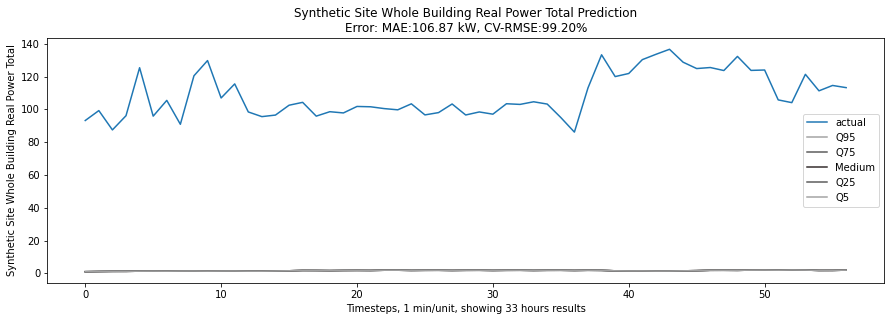

In [12]:
plt.figure(figsize=(15, 4.5))

# calculating error
y_actual = actual
y_predicted = q50.values.flatten()
MSE = mean_squared_error(y_actual, y_predicted)
RMSE = MSE**0.5
CV_RMSE = RMSE/y_actual.mean().values[0]
mae = mean_absolute_error(y_actual, y_predicted)

plt.title(f'{site} Whole Building Real Power Total Prediction\nError: MAE:{mae:.2f} kW, CV-RMSE:{CV_RMSE*100:.2f}%')

plt.plot(actual, label = 'actual')
plt.plot(sg_filter(q95.values.flatten(),5,2), label = 'Q95', color = '#a2a2a2')
plt.plot(sg_filter(q75.values.flatten(),5,2), label = 'Q75', color = '#5b5b5b')
plt.plot(sg_filter(q50.values.flatten(),5,2), label = 'Medium', color = '#322b2b')
plt.plot(sg_filter(q25.values.flatten(),5,2), label = 'Q25', color = '#5b5b5b')
plt.plot(sg_filter(q05.values.flatten(),5,2), label = 'Q5', color = '#a2a2a2')


plt.legend()

# plt.ylim(20,40)
# n=0
# plt.xlim(1000, 1720)

plt.ylabel(f'{site} Whole Building Real Power Total')
plt.xlabel('Timesteps, 1 min/unit, showing 33 hours results')

plt.show()